# White wine classification with kernel methods

The dataset represent white variants of the Portuguese "Vinho Verde" wine.
There are 11 input variables: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates and alcohol.
The output variable is the quality (score between 0 and 10).
The classes are ordered and unbalanced, there is much wines concentrated in the mean value 6. 

The problem is turned into a binary classification problem; the data are divided in 2 quality classes: good and bad.

We apply a classification and a regression algorithm.
We consider the Support Vector Machines and the Ridge regression which are both linear algorithms.
In order to improve the prediction, we employ the kernel trick which allows to apply a linear algorithm on a non-linear problem.
We study the influence of the hyper-parameter $\gamma$ of the kernel.

Outline:
* Exploratory Data Analysis
* Data processing
* Classification and Regression with kernel

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import accuracy_score
from sklearn import kernel_ridge
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.datasets import make_classification
from sklearn.utils.fixes import signature

# 1) Exploratory Data Analysis

In [2]:
data = pd.read_csv('winequality-white.csv', sep=';')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## 1.1) Data distribution

In [3]:
data['quality'].unique()

array([6, 5, 7, 8, 4, 3, 9])

The target variable "quality" ranges from 3 to 9. 

In [4]:
data['quality'].describe()

count    4898.000000
mean        5.877909
std         0.885639
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64

The median and 75th percentile values are both 6 out of 9.

**=> unbalanced dataset**

Text(0.5,1,'White wines')

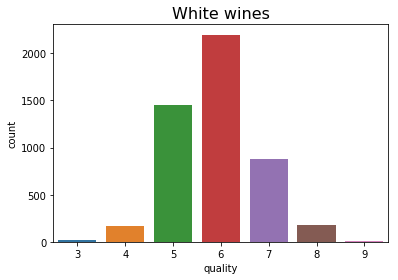

In [5]:
sns.countplot(data=data, x="quality")
plt.title("White wines", fontsize=16)

We observe that values 5 and 6 are more than 2/3 of the dataset.
Below we depict the distribution of each feature with respect to the quality.

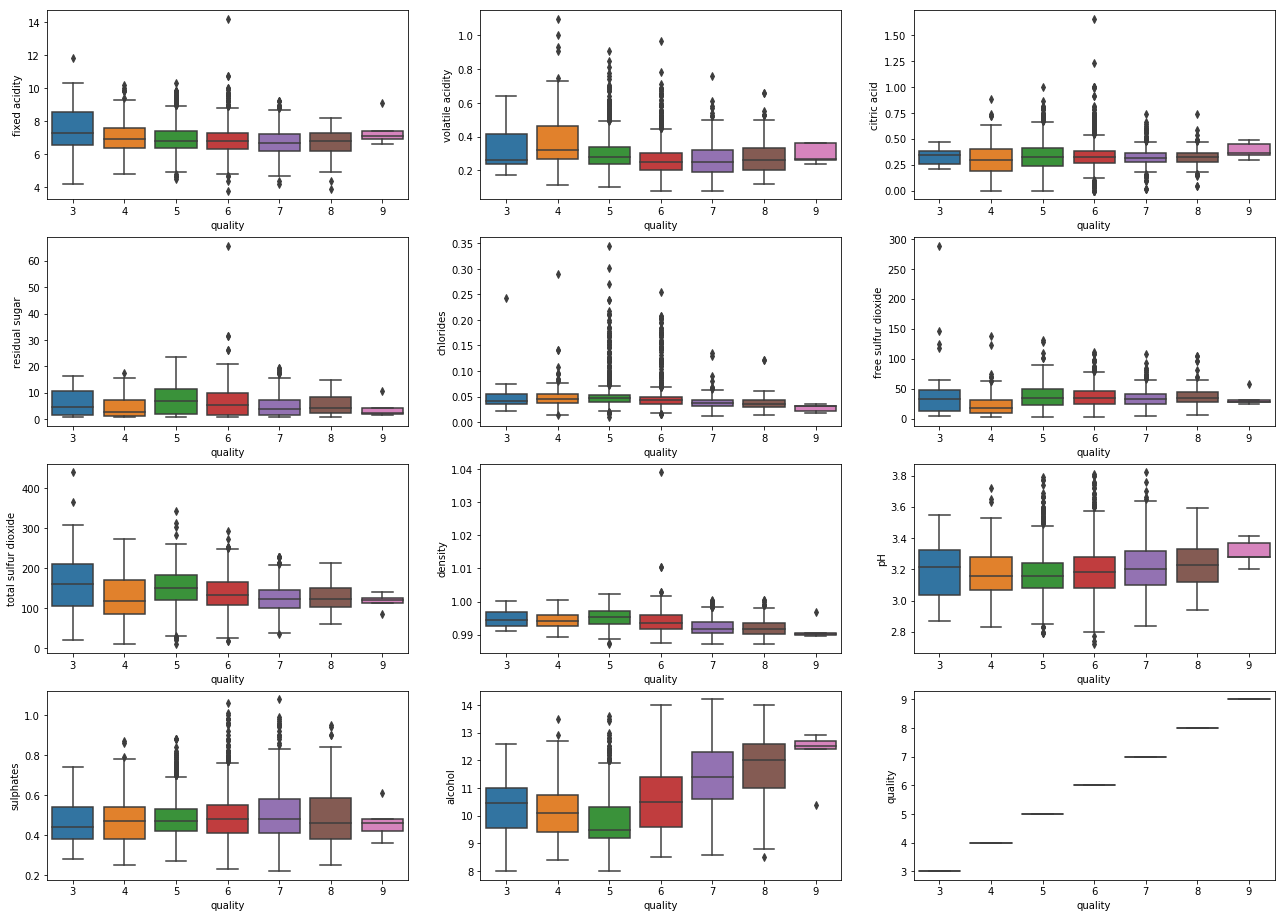

In [6]:
fig, ax1 = plt.subplots(4,3, figsize=(22,16))
k = 0
for i in range(4):
    for j in range(3):
        sns.boxplot('quality',data.iloc[:,k], data=data, ax = ax1[i][j])
        k += 1
plt.show()

The dataset contains several outliers, this can be related to the unbalance of values.

## 1.2) Correlations

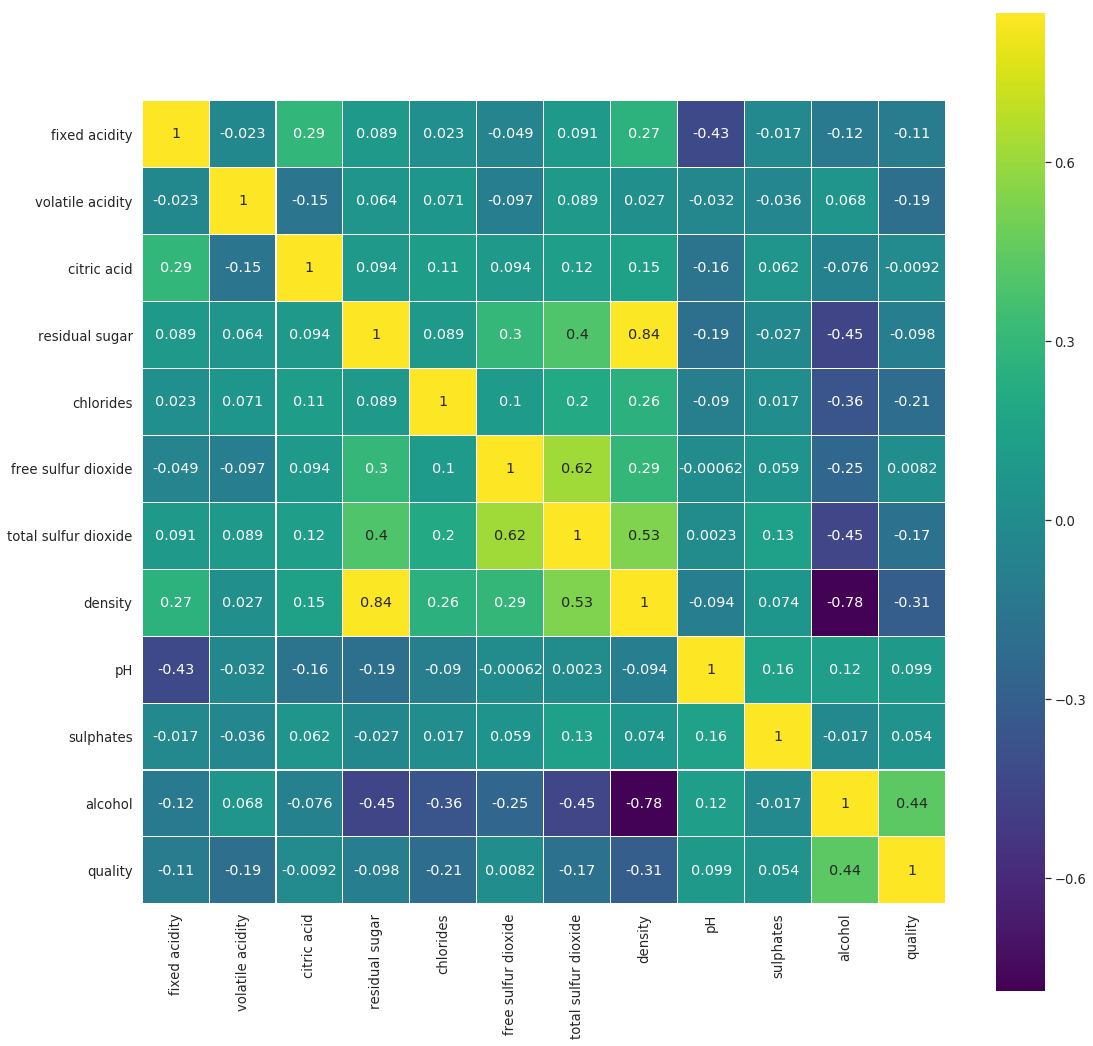

In [7]:
corrmat = data.corr()
colormap = plt.cm.viridis
plt.figure(figsize=(18,18))
sns.set(font_scale=1.2)
sns.heatmap(corrmat, vmax=.85, vmin=-0.79,
            linewidths=0.05,
            square=True, cmap=colormap, 
            annot=True)

Alcohol positively correlates most with quality than any of the other features at 0.44.
Overall, there are very few features strongly correlated with one another. 
Thus, each feature brings unique information and no feature selection is proceeded here.

# 2) Data processing

## 2.1) Binary classification   
    
We divide the dataset in two classes separating good wines from bad wines.
We choose an arbitrary cutoff at 5, meaning that higher quality wines getting classified as good and the remainder as bad.

An additional column "quality_label" is filled with the corresponding value 1 for 'good' and 0 for 'bad' wine.

In [8]:
def binary_class(quality):
    if quality > 5:
        return 1
    else:
        return 0
data['quality_label'] = data['quality'].apply(binary_class)
data['quality_label'].value_counts()

1    3258
0    1640
Name: quality_label, dtype: int64

Text(0.5,1,'White wines quality')

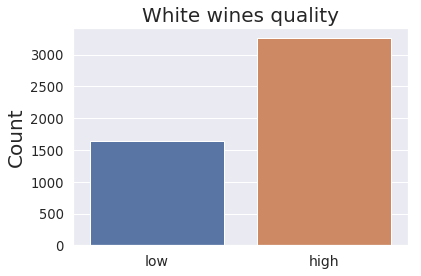

In [9]:
sns.countplot(data=data, x="quality_label")
plt.xticks([0,1],['low', 'high'], fontsize=14)
plt.xlabel('')
plt.ylabel('Count', fontsize=20)
plt.title("White wines quality", fontsize=20)

The dataset is still unbalanced. As a consequence, a great care has to be taken in the modelling and the performance evaluation metric.

In [10]:
X = data.drop(['quality','quality_label'], axis =1)
y_class = data['quality_label']

## 2.2) Splitting and standardising

In [11]:
X_train, X_test, y_train, y_test = \
model_selection.train_test_split(X, y_class, test_size=0.3, 
                                 stratify=y_class, random_state=2)

In [12]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

# 3) Classification and regression with kernel

In case of non-linear problem, a non-linear decision function is required.
A strategy consists in applying a linear transformation to the data, and to apply a linear algorithm on the transformed data.
Let the data $(x_1,...,x_n)\in\mathbb{R}^n$, we consider a linear transformation $\phi: \mathbb{R}^n  \to H$, where $H$ is the redescription space.
A linear algorithm can be apply to $(\phi(x_1), ..., \phi(x_n))$ in the redescription space.
Nevertheless, the dimension of the redescription space is larger than the dimension of the initial space.
Consequently, the problem to tackle is the higher dimension.

Taking into account the optimization problem involves a scalar product $<\phi(x),\phi(y)>_H$ in $H$.
The kernel trick consists in replacing this scalar product, in a high dimension space $H$, by a kernel function $k$ easy to calculate.
We consider a kernel function $k(x,y)=<\phi(x),\phi(y)>_H$ instead of $\phi$, thus $\phi$ is not required explicitly and there is need to make computations in high dimension.
For example, the initial space can be transformed into a redescription space with infinite dimension, as the gaussian kernel $k(x,y)=\exp(-\dfrac{||x-y||^2}{2\sigma^2})$  with $(x,y)\in\mathbb{R}^n\times\mathbb{R}^n$ and $\sigma>0$.

The method is relevant for both classification and regression problems, and the kernel trick can be applied to linear models such as Support Vector Machines (SVM) or Regression Ridge as presented in what follows.

<!-- on apprend une fonction g linéaire sur les données transformées {Φ(x1),Φ(x2),…,Φ(xn)} et leurs étiquettes {y1,y2,…,yn}. 
The function g is linear in $\phi(x)$ but the decision function $f=g o \phi$ is not linear.
linear problem in higher dimension space <=> non-linear problem in initial space
How to choose $\phi$ and H? How to learn efficiently in a redescription space with high dimension?
Les SVM à noyaux sont implémentées dans scikit-learn dans les classes sklearn.svm.SVC pour la classification et sklearn.svm.SVR pour la régression. 
L'astuce du noyau s'applique aussi à la version « régression » des SVMs, à savoir, la SVR.
1) svm.SVC
2) svm.SVR
\begin{equation}
k(x,y)=\exp(-\dfrac{||x-y||^2}{2\sigma^2}), \quad (x,y)\in\mathbb{R}^n\times\mathbb{R}^n
\end{equation}
--
x~x' => K(x,x')~1
x-x' infty => K(x,x') = 0
-->


## 3.1) Support Vector Machines with kernel

In the Kernel version of SVM, the SVM algorithm is applied on the image the data by $\phi$ in $H$, leading to a non-linear model in the initial space.
Thus, the Kernel SVM provides a non-linear version of SVM.
The Kernel SVM is implemented in scikit-learn in sklearn.svm.SVC, and the kernel is specified with the 'kernel' parameter which can be linear, polynomial, Radial Basis Function (RBF), sigmoid etc.
We consider the RBF Gaussian kernel $k(x,y)=\exp(-\gamma||x-y||^2)$ where $\gamma>0$ stands for $\dfrac{1}{2\sigma^2}$.

### 3.1.1) Default SVM kernel

In order to provide a baseline result of reference, we adopt the default SVM kernel implemented in scikit-learn. 
The paramater $C$, which stands for a regularization parameter, has the default value $1$, and we set the $\gamma$ parameter to $0.01$.

We present the classification report, we plot the ROC curve on the test set and give the Area Under the Curve.

In [13]:
gamma = 0.01
classifier = svm.SVC(kernel='rbf', gamma=gamma)
classifier.fit(X_train_std, y_train)
y_pred = classifier.predict(X_test_std)

print("Classification report:\n", classification_report(y_test,y_pred))
accuracy = accuracy_score(y_test, y_pred) 
print("Accuracy %.2f%%" % (accuracy*100)) 

Classification report:
              precision    recall  f1-score   support

          0       0.73      0.48      0.58       492
          1       0.78      0.91      0.84       978

avg / total       0.76      0.77      0.75      1470

Accuracy 76.53%


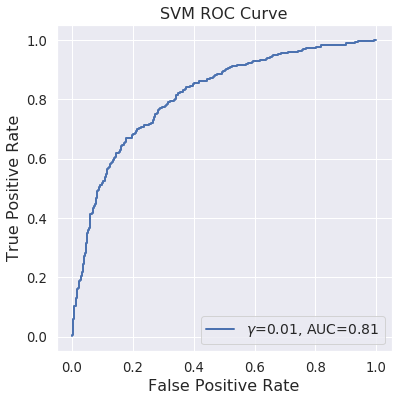

In [14]:
y_pred = classifier.decision_function(X_test_std)
fpr, tpr, thr = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
fig = plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, '-', lw=2, label='$\gamma$=0.01, AUC=%.2f' % auc)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('SVM ROC Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.show()

### 3.1.2) Grid search

In order to improve the results, we perform a [Cross-validation](https://github.com/christelle-git/Cross-validation/) on the test set using GridSearchCV which searchs for optimal values leading to the best performance.
The grid parameters takes into account a value range for $C$ and $\gamma$.
We consider the AUC-ROC for the scoring, but a F-mesure could be considered as well.

We present the classification report, we plot the ROC curve on the test set and give the Area Under the Curve.

In [15]:
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-2, 1, 4)
param_grid = {'C': C_range, 'gamma': gamma_range}
score = 'roc_auc'
grid = GridSearchCV(svm.SVC(kernel='rbf'), 
                            param_grid, 
                            cv=5,   
                            scoring=score,
                            n_jobs=-1)
grid.fit(X_train_std, y_train)
print("The optimal parameters are %s with a score of %.2f" % \
      (grid.best_params_, grid.best_score_))

y_pred = grid.predict(X_test_std)
print("Classification report:\n", classification_report(y_test,y_pred))
accuracy = accuracy_score(y_test, y_pred) 
print("Accuracy %.2f%%" % (accuracy*100)) 

The optimal parameters are {'C': 1.0, 'gamma': 1.0} with a score of 0.85
Classification report:
              precision    recall  f1-score   support

          0       0.81      0.50      0.62       492
          1       0.79      0.94      0.86       978

avg / total       0.80      0.79      0.78      1470

Accuracy 79.39%


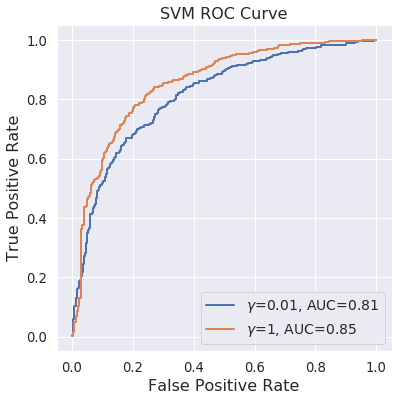

In [16]:
y_pred_cv = grid.decision_function(X_test_std)
fpr_cv, tpr_cv, thr_cv = metrics.roc_curve(y_test, y_pred_cv)
auc_cv = metrics.auc(fpr_cv, tpr_cv)
fig = plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, '-', lw=2, label='$\gamma$=0.01, AUC=%.2f' % auc)
plt.plot(fpr_cv, tpr_cv, '-', lw=2, label='$\gamma$=%.1d, AUC=%.2f' % \
         (grid.best_params_['gamma'], auc_cv))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('SVM ROC Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.show()

With the Grid Search strategy, the results are improved about 4%.

### 3.1.3) The Gram matrix

In this subsection, we visualize the $\gamma$ influence.
Indeed, $\gamma$ controls the bandwidth of the Gaussian: the higher $\gamma$ is, the smaller the distance between x and y must be for the kernel to be different from 0.
To illustrate this effect, we visualize the Gram matrix $K_{ij} = k(x_i, x_j)$ with $(i,j)\in\{1,n\}$.

If all values of the Gram matrix are close to each other, the SVM can't learn well: all points are almost identical.
If the Gram matrix is strongly  diagonally dominant, it means that each point is extremely different to others, thus the SVM is not able to learn well either.

We illustrate this behavior below by plotting the Gram matrix with $\gamma=0.01$ and $\gamma=50$.

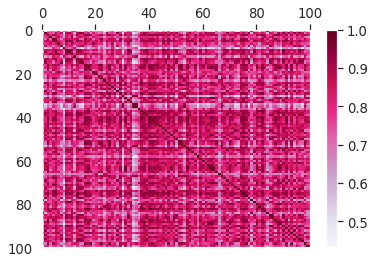

In [17]:
kmatrix = metrics.pairwise.rbf_kernel(X_train_std, gamma=0.01)
kmatrix100 = kmatrix[:100, :100]
plt.pcolor(kmatrix100, cmap = 'PuRd') 
plt.colorbar()
plt.xlim([0, 100]) 
plt.ylim([0, 100]) 
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.show()

The kernel values are between 0.40 and 1.0, with a slightly dominant diagonal.

With a larger gamma value, gamma = 50, the following Gram matrix is obtained.

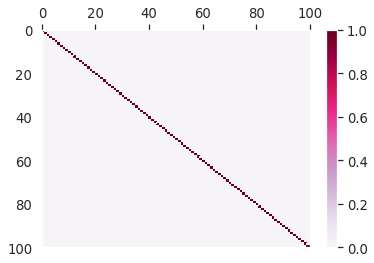

In [18]:
kmatrix = metrics.pairwise.rbf_kernel(X_train_std, gamma=50)
kmatrix100 = kmatrix[:100, :100]
plt.pcolor(kmatrix100, cmap = 'PuRd') 
plt.colorbar()
plt.xlim([0, 100]) 
plt.ylim([0, 100]) 
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.show()

This matrix is diagonally dominant. 

Therefors, a kernel SVM algorithm run with this $\gamma$ value would provide a worser result, as illustrated below.

Classification report:
              precision    recall  f1-score   support

          0       1.00      0.25      0.40       492
          1       0.73      1.00      0.84       978

avg / total       0.82      0.75      0.69      1470

Accuracy 74.83%


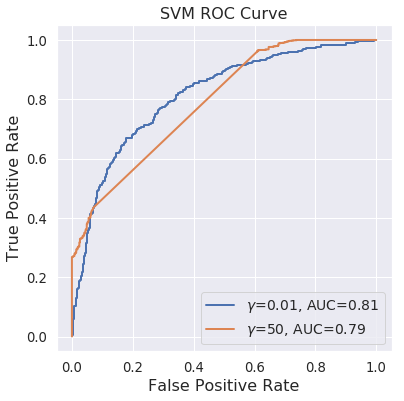

In [19]:
gamma = 50
classifier = svm.SVC(kernel='rbf', gamma=gamma)
classifier.fit(X_train_std, y_train)
y_pred = classifier.predict(X_test_std)

print("Classification report:\n", classification_report(y_test,y_pred))
accuracy = accuracy_score(y_test, y_pred) 
print("Accuracy %.2f%%" % (accuracy*100)) 

y_pred = classifier.decision_function(X_test_std)
fpr_50, tpr_50, thr_50 = metrics.roc_curve(y_test, y_pred)
auc_50 = metrics.auc(fpr_50, tpr_50)
fig = plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, '-', lw=2, label='$\gamma$=0.01, AUC=%.2f' % auc)
plt.plot(fpr_50, tpr_50, '-', lw=2, label='$\gamma$=50, AUC=%.2f' % auc_50)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('SVM ROC Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.show()

###  Conclusion

The optimization of the model must take into account the $\gamma$ parameter value defining the kernel.

## 3.2) Ridge Regression with kernel

In this section we adopt a regression algorithm coupled with the kernel trick.
More precisely, we consider the Kernel Ridge regression (kRR).
The kRR combines the [Ridge regression](https://github.com/christelle-git/prostate-cancer-prediction/) with the kernel trick. 

The Kernel Ridge regression is implemented in scikit-learn in kernel_ridge.KernelRidge.
We consider the RBF Gaussian kernel $k(x,y)=\exp(-\gamma||x-y||^2)$ as in the previous section.

### 3.2.1) Default kernel Ridge Regressor

We adopt the kernel Ridge Regression of scikit-learn with $\gamma=0.01$.
The $\alpha$ parameters which corresponds to $(2C)^{-1}$ in LinearSVC is set to $1$ as the default parametrization.

We present the Root Means Square Error (RMSE), and we plot True values with respect to the Predicted values in $[0,1]\times I$ where $I$ is the range of the predicted values.

In [20]:
predicteur = kernel_ridge.KernelRidge(alpha=1.0, kernel='rbf', gamma=0.01)  

predicteur.fit(X_train_std, y_train)
y_pred = predicteur.predict(X_test_std)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: %.2f" % rmse)

Root Mean Squared Error: 0.40


In order to illustrate the distribution of the predicted values, we plot the True values against the Predicted values weighted by their amount. We assign an amplitude value and add it to each occurence of predicted value. 

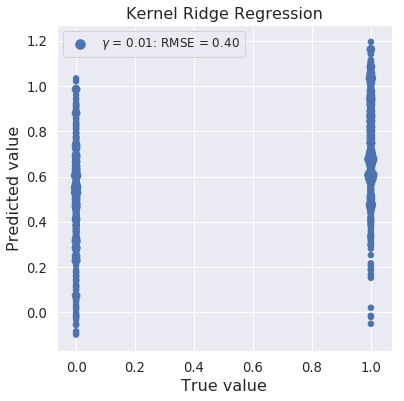

In [21]:
fig = plt.figure(figsize=(6, 6))
sizes = {}
amp = 30
for (yt, yp) in zip(list(y_test), list(y_pred)):
    if (yt, yp) in sizes:
        sizes[(yt, yp)] += amp
    else:
        sizes[(yt, yp)] = amp     
keys = sizes.keys()
plt.scatter([k[0] for k in keys], 
            [k[1] for k in keys], 
             s=[sizes[k] for k in keys], 
            label='$\gamma$ = 0.01: RMSE = %0.2f' % rmse)
plt.xlabel('True value', fontsize=16)
plt.ylabel(u'Predicted value', fontsize=16)
plt.title('Kernel Ridge Regression', fontsize=16)
plt.legend(loc="upper left", fontsize=12)

We observe the predicted values are almost uniformly distributed in $[0,1.2]$

### 3.2.2) Grid search

In [22]:
alpha_range = np.logspace(-2, 2, 5)
gamma_range = np.logspace(-2, 1, 4)
param_grid = {'alpha': alpha_range, 'gamma': gamma_range}
score = 'neg_mean_squared_error'

grid_pred = GridSearchCV(kernel_ridge.KernelRidge(kernel='rbf'),
                        param_grid,
                        cv=5,
                        scoring=score,
                        n_jobs=-1)
grid_pred.fit(X_train_std, y_train)
y_pred_cv = grid_pred.predict(X_test_std)
rmse_cv = np.sqrt(metrics.mean_squared_error(y_test, y_pred_cv))
print("The optimal parameters are %s with a score of %.2f" % \
      (grid_pred.best_params_, grid_pred.best_score_))
print("\nRoot Mean Squared Error: %.2f" % rmse_cv)

The optimal parameters are {'alpha': 1.0, 'gamma': 0.1} with a score of -0.15

Root Mean Squared Error: 0.39


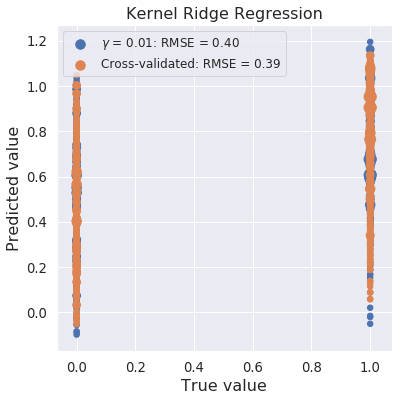

In [23]:
fig = plt.figure(figsize=(6, 6))
sizes_cv = {}
for (yt, yp) in zip(list(y_test), list(y_pred_cv)):
    if (yt, yp) in sizes_cv:
        sizes_cv[(yt, yp)] += amp
    else:
        sizes_cv[(yt, yp)] = amp     
keys_cv = sizes_cv.keys()
plt.scatter([k[0] for k in keys], 
            [k[1] for k in keys], 
             s=[sizes[k] for k in keys], 
            label='$\gamma$ = 0.01: RMSE = %0.2f' % rmse)
plt.scatter([k[0] for k in keys_cv], 
            [k[1] for k in keys_cv], 
             s=[sizes_cv[k] for k in keys_cv], 
            label='Cross-validated: RMSE = %0.2f' % rmse_cv)

plt.xlabel('True value', fontsize=16)
plt.ylabel(u'Predicted value', fontsize=16)
plt.title('Kernel Ridge Regression', fontsize=16)
plt.legend(loc="upper left", fontsize=12)

The predictions are roughly superimposed on those obtained with $\gamma = 0.01$.

A slightly better RMSE is obtained by optimizing the model.

### 3.2.3) The $\gamma$ influence

In the section 3.1.3) of the kernel SVM we have found that a high value of $\gamma$ leads to a poor result.
Herein, we illustrate the $\gamma$ influence.

We consider the kRR with $\gamma = 50$ and we obtain the following poor predictions:

Root Mean Squared Error: 0.72


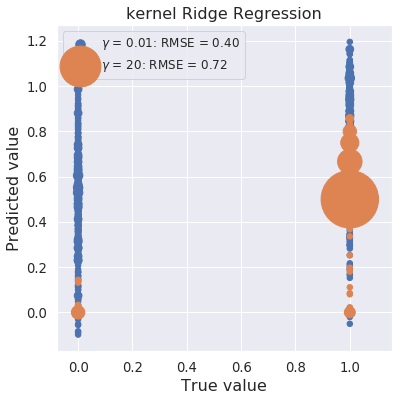

In [24]:
predicteur = kernel_ridge.KernelRidge(alpha=1.0, kernel='rbf', gamma=50)   

predicteur.fit(X_train_std, y_train)
y_pred_g = predicteur.predict(X_test_std)
rmse_g = np.sqrt(metrics.mean_squared_error(y_test, y_pred_g))
print("Root Mean Squared Error: %.2f" % rmse_g)


fig = plt.figure(figsize=(6, 6))
sizes_g = {}
for (yt, yp) in zip(list(y_test), list(y_pred_g)):
    if (yt, yp) in sizes_g:
        sizes_g[(yt, yp)] += amp
    else:
        sizes_g[(yt, yp)] = amp     
keys_g = sizes_g.keys()
plt.scatter([k[0] for k in keys], 
            [k[1] for k in keys], 
             s=[sizes[k] for k in keys], 
            label='$\gamma$ = 0.01: RMSE = %0.2f' % rmse)
plt.scatter([k[0] for k in keys_g], 
            [k[1] for k in keys_g], 
             s=[sizes_g[k] for k in keys_g], 
            label='$\gamma$ = 20: RMSE = %0.2f' % rmse_g)
plt.xlabel('True value', fontsize=16)
plt.ylabel(u'Predicted value', fontsize=16)
plt.title('kernel Ridge Regression', fontsize=16)
plt.legend(loc="upper left", fontsize=12)

The RMSE is almost 50% worser with $\gamma=50$ than with $\gamma=0.01$.

Predictions with $\gamma = 50$ are of very poor quality: 
 * concentrated in 0.5 for good quality wines (quality = 1), 
 * concentrated in 1.1 for poor quality wines (quality = 0).

## 3.3) Conclusion

The kernel trick allows to improve the performance of linear models, but it requires an additional hyperparameter: the kernel parameter.
The behavior of the model is very sensitive to the $\gamma$ parameter of the Gaussian RBF kernel.

In our context, we have observed that the $\gamma$ parameter plays an important role: if $\gamma \to \infty$, the Gram matrix is diagonnaly dominant and the algorithm can't learn. 
The model selection might take care of the kernel parameter value in addition to the others parameters.
A cross-validation strategy coupled with a grid search is required to optimize all the parameters.

Besides, it is worth mentionning that in practice, to train a kRR is more efficient than a kernel SVM since the solution is analytical, however predicting is faster with a kernel SVM.